# Make a function to extract and write csv with rois and labels

In [10]:
import os
import re
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from itertools import cycle
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from joblib import Parallel, delayed
import multiprocessing
%matplotlib inline

parcellation_name='power_drysdale'
input_file_list_fname = "../post_processing/rs_files_and_exclusions.csv"
parcel_labels_fname='../power_spheres/power_drysdale_labels.csv'
label_image_fname='../power_spheres/power_drysdale_spheres.nii'
rsfc_derivs_dir="/data/mounts/scs-fs-20/kpsy/genr/users/jflournoy/rsfc_derivatives/"
num_cores = 4

def time_course_extractor(connectivity_obj):
    def extract(fname, masker_fname):
        if os.path.isfile(fname) and os.path.isfile(masker_fname):
            masker_obj = NiftiLabelsMasker(labels_img=masker_fname, 
                                           standardize=True,
                                           memory='nilearn_cache',
                                           verbose=5)
            anImg = nib.load(fname)
            time_series = masker_obj.fit_transform(anImg)
            cormat = connectivity_obj.fit_transform([time_series])[0]
        else:
            time_series = []
            cormat = []
        return time_series, cormat
    return extract

def make_extract_arg_zips(input_filenames, label_def_filename, exclude):
    #if the poarcel fname is a list, then assume it has a list of subject-specific 
    #label files
    input_file_list_include = input_filenames.loc[exclude == 0,'file'].values
    
    label_image_file_is_nii = re.match(".*nii$", label_def_filename)
    label_image_file_is_csv = re.match(".*csv$", label_def_filename)
    if label_image_file_is_nii:
        print("Using {} to parcellate all images...".format(label_def_filename))
        extract_args_zip = zip(list(input_file_list_include), cycle([label_def_filename]))
    elif label_image_file_is_csv:
        print("Using list of parcellation files from ".format(label_def_filename))
        raise Exception("TEST THIS CODE FIRST")
        label_image_fnames = pd.read_csv(label_def_filename)
        label_image_fnames_include = label_image_fnames.loc[exclude == 0,'file'].values
        if len(input_file_list_include) != label_image_fnames_include:
            raise Exception("List of resting-state and label images do not match: {} and {}".format(len(input_file_list_include), label_image_fnames_include))
        extract_args_zip = zip(input_filenames, label_image_fnames_include)
    else:
        raise Exception("Label definition is neither .nii or .csv: {}".format(label_def_filename))
    
    return extract_args_zip

timecourse_dir = os.path.join(rsfc_derivs_dir, parcellation_name)
connectivity_mat_dir = os.path.join(rsfc_derivs_dir, parcellation_name)

for path in [timecourse_dir, connectivity_mat_dir]:
    if not os.path.isdir(path):
        try:
            os.makedirs(path)
        except:
            print("Cannot make dir {}".format(path))
            raise

#get our labels -- these are just network labels
input_file_list = pd.read_csv(input_file_list_fname)
label_df = pd.read_csv(parcel_labels_fname)
labels = list(label_df['label'].values)

connectivity_obj = ConnectivityMeasure(kind='correlation')

print("Processing input file list...")
if 'exclude' in input_file_list.columns:
    exclude = input_file_list.exclude.values
    print("Found {} exclusions.".format(sum(exclude)))
else:
    print("No exclusions found in file list; assuming no files will be excluded.")
    exclude = [0]*input_file_list.file.shape[0]

extract_corrs = time_course_extractor(connectivity_obj)
extract_args_zip = make_extract_arg_zips(input_file_list.loc[0:9,], label_image_fname, exclude[0:9,])

Processing input file list...
Found 0 exclusions.
Using ../power_spheres/power_drysdale_spheres.nii to parcellate all images...


In [11]:
import time
t0 = time.time()
results = Parallel(n_jobs=num_cores, verbose=10)(delayed(extract_corrs)(f, l) for f, l in extract_args_zip)
t1 = time.time()
total = t1-t0


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:    1.7s remaining:    3.3s
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:    1.7s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:    3.3s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    5.0s finished


In [12]:
print("3420 participants would take about {} hours to complete...".format(np.round(total*num_cores/(len(input_file_list.loc[0:9,]))*3240/60/60, 2)))

3420 participants would take about 1.81 hours to complete...


In [13]:
for result in results:
    for sub in result:
        print(sub.shape)
        

(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)
(195, 280)
(280, 280)


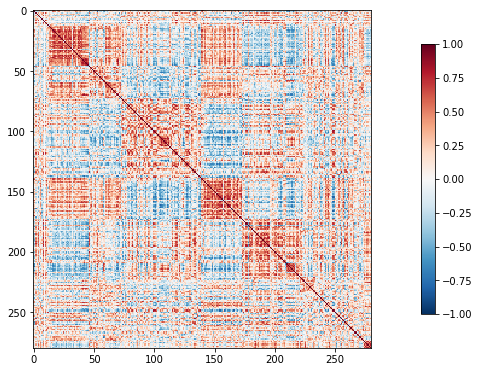

In [14]:
plotting.plot_matrix(results[0][1], vmax=1, vmin=-1)

(array([ 108., 1215., 3516., 5661., 7461., 7307., 6398., 4594., 2324.,
         476.]),
 array([-0.8727679 , -0.6958944 , -0.5190209 , -0.34214738, -0.16527386,
         0.01159966,  0.18847318,  0.3653467 ,  0.54222023,  0.71909374,
         0.89596725], dtype=float32),
 <a list of 10 Patch objects>)

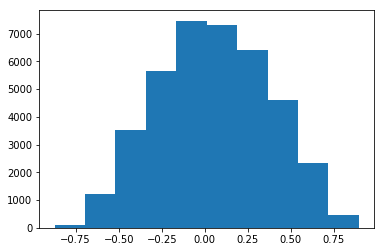

In [19]:
uppertri = results[0][1][np.triu_indices_from(results[0][1], k=1)]
plt.pyplot.hist(uppertri)

In [ ]:
print(cormats[0].shape)
len(cormats[0][np.triu_indices_from(cormats[0], k=1)])

In [ ]:
280*(280-1)/2*3429
testdf = pd.DataFrame(cormats[0][np.triu_indices_from(cormats[0], k=1)])

In [ ]:
import sys
print(sys.getsizeof(testdf))
testdf.info()